# 9. Recursive Neural Networks and Constituency Parsing

In [ ]:
!python3 --version

Python 3.10.12


I recommend you take a look at these material first.

* http://web.stanford.edu/class/cs224n/lectures/cs224n-2017-lecture14-TreeRNNs.pdf
* https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf

In [ ]:
import random
import pickle
import numpy as np
from collections import OrderedDict
import os
from IPython.display import display
from nltk.tree import Tree as nltkTree
import torch
import torch.nn as nn
from torch.nn.init import xavier_uniform_, zeros_
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau
flatten = lambda l: [item for sublist in l for item in sublist]
random.seed(1024)

In [ ]:
torch.cuda.is_available()
gpu = '0'
# 设置使用哪些显卡进行训练
os.environ["CUDA_VISIBLE_DEVICES"] = gpu

In [ ]:
def getBatch(batch_size, train_data):
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch

    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch

In [ ]:

print(os.getcwd())

/content


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Stanford Sentiment Treebank(https://nlp.stanford.edu/sentiment/index.html)

In [ ]:
sample = random.choice(open('/content/drive/MyDrive/dataset/train.txt', 'r', encoding='utf-8').readlines())
print(sample)

(4 (3 (2 (1 -LRB-) (2 (2 A) (3 -RRB-))) (4 (3 (4 (3 wonderfully) (1 loopy)) (2 tale)) (3 (2 of) (2 (3 (3 (3 (2 (4 love) (2 ,)) (2 longing)) (2 ,)) (2 and)) (2 voting))))) (2 .))



In [ ]:
!pip install svgling

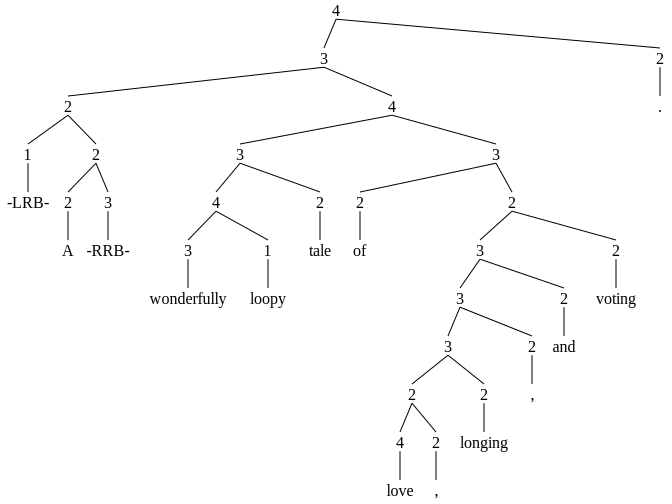

In [ ]:
tree = nltkTree.fromstring(sample)
display(tree)

### Tree Class

borrowed code from https://github.com/bogatyy/cs224d/tree/master/assignment3

In [ ]:
class Node:  # a node in the tree
    def __init__(self, label, word=None):
        self.label = label
        self.word = word
        self.parent = None  # reference to parent
        self.left = None  # reference to left child
        self.right = None  # reference to right child
        # true if I am a leaf (could have probably derived this from if I have
        # a word)
        self.isLeaf = False
        # true if we have finished performing fowardprop on this node (note,
        # there are many ways to implement the recursion.. some might not
        # require this flag)

    def __str__(self):
        if self.isLeaf:
            return '[{0}:{1}]'.format(self.word, self.label)
        return '({0} <- [{1}:{2}] -> {3})'.format(self.left, self.word, self.label, self.right)


class Tree:

    def __init__(self, treeString, openChar='(', closeChar=')'):
        tokens = []
        self.open = '('
        self.close = ')'
        for toks in treeString.strip().split():
            tokens += list(toks)
        self.root = self.parse(tokens)
        # get list of labels as obtained through a post-order traversal
        self.labels = get_labels(self.root)
        self.num_words = len(self.labels)

    def parse(self, tokens, parent=None):
        assert tokens[0] == self.open, "Malformed tree"
        assert tokens[-1] == self.close, "Malformed tree"

        split = 2  # position after open and label
        countOpen = countClose = 0

        if tokens[split] == self.open:
            countOpen += 1
            split += 1
        # Find where left child and right child split
        while countOpen != countClose:
            if tokens[split] == self.open:
                countOpen += 1
            if tokens[split] == self.close:
                countClose += 1
            split += 1

        # New node
        node = Node(int(tokens[1]))  # zero index labels

        node.parent = parent

        # leaf Node
        if countOpen == 0:
            node.word = ''.join(tokens[2: -1]).lower()  # lower case?
            node.isLeaf = True
            return node

        node.left = self.parse(tokens[2: split], parent=node)
        node.right = self.parse(tokens[split: -1], parent=node)

        return node

    def get_words(self):
        leaves = getLeaves(self.root)
        words = [node.word for node in leaves]
        return words


def get_labels(node):
    if node is None:
        return []
    return get_labels(node.left) + get_labels(node.right) + [node.label]


def getLeaves(node):
    if node is None:
        return []
    if node.isLeaf:
        return [node]
    else:
        return getLeaves(node.left) + getLeaves(node.right)

def loadTrees(dataSet='train', transformer=True):
    """
    Loads training trees. Maps leaf node words to word ids.
    """
    file = '/content/drive/MyDrive/dataset/%s.txt' % dataSet
    print("Loading %s trees.." % dataSet)
    with open(file, 'r', encoding='utf-8') as fid:
        if transformer:
            trees = [Tree(l) for l in fid.readlines()]
        else:
            trees = [l for l in fid.readlines()]

    return trees

'''
def loadTrees(dataSet='train', transformer=True, subset_frac=0.01, use_saved_subset=True):
    """
    Loads a subset of training trees. Maps leaf node words to word ids.
    Args:
        dataSet (str): Name of the dataset (train, test, etc.).
        transformer (bool): Whether to transform lines into Tree objects.
        subset_frac (float): Fraction of the dataset to load as a subset.
        use_saved_subset (bool): Whether to use a saved subset if available.
    """
    subset_file = f'/content/drive/MyDrive/dataset/{dataSet}_subset.pkl'

    # Check if a saved subset exists and load it
    if use_saved_subset and os.path.exists(subset_file):
        print(f"Loading {dataSet} trees from saved subset...")
        with open(subset_file, 'rb') as f:
            trees = pickle.load(f)
        return trees

    print(f"Loading {dataSet} trees...")
    file_path = f'/content/drive/MyDrive/dataset/{dataSet}.txt'
    with open(file_path, 'r', encoding='utf-8') as fid:
        lines = fid.readlines()

    # Randomly select a subset of the trees
    subset_size = int(len(lines) * subset_frac)
    selected_lines = random.sample(lines, subset_size)

    # Transform lines into Tree objects if needed
    if transformer:
        trees = [Tree(line) for line in selected_lines]
    else:
        trees = selected_lines

    # Save the selected subset for future use
    with open(subset_file, 'wb') as f:
        pickle.dump(trees, f)

    return trees
'''

'\ndef loadTrees(dataSet=\'train\', transformer=True, subset_frac=0.01, use_saved_subset=True):\n    """\n    Loads a subset of training trees. Maps leaf node words to word ids.\n    Args:\n        dataSet (str): Name of the dataset (train, test, etc.).\n        transformer (bool): Whether to transform lines into Tree objects.\n        subset_frac (float): Fraction of the dataset to load as a subset.\n        use_saved_subset (bool): Whether to use a saved subset if available.\n    """\n    subset_file = f\'/content/drive/MyDrive/dataset/{dataSet}_subset.pkl\'\n\n    # Check if a saved subset exists and load it\n    if use_saved_subset and os.path.exists(subset_file):\n        print(f"Loading {dataSet} trees from saved subset...")\n        with open(subset_file, \'rb\') as f:\n            trees = pickle.load(f)\n        return trees\n\n    print(f"Loading {dataSet} trees...")\n    file_path = f\'/content/drive/MyDrive/dataset/{dataSet}.txt\'\n    with open(file_path, \'r\', encoding=\'

In [ ]:
train_data = loadTrees('train')

Loading train trees..


### Build Vocab

In [ ]:
vocab = list(set(flatten([t.get_words() for t in train_data])))

In [ ]:
word2index = {'<UNK>': 0}
for vo in vocab:
    if word2index.get(vo) is None:
        word2index[vo] = len(word2index)

index2word = {v: k for k, v in word2index.items()}

## Modeling

In [ ]:
class Accumulator:
    def __init__(self, optimizer, accumulate_steps):
        self.optimizer = optimizer
        self.accumulate_steps = accumulate_steps
        self.step_count = 0

    def accumulate(self):
        self.step_count += 1
        if self.step_count % self.accumulate_steps == 0:
            self.optimizer.step()
            self.optimizer.zero_grad()

    def zero_grad(self):
        self.step_count = 0
        self.optimizer.zero_grad()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class RNTN(nn.Module):
    def __init__(self, word2index, hidden_size, output_size):
        super(RNTN, self).__init__()
        self.word2index = word2index
        self.embed = nn.Embedding(len(word2index), hidden_size).to(device)
        self.param_list = nn.ParameterList([nn.Parameter(torch.randn(hidden_size * 2, hidden_size * 2)).to(device) for _ in range(hidden_size)])
        self.W = nn.Parameter(torch.randn(hidden_size * 2, hidden_size)).to(device)
        self.b = nn.Parameter(torch.zeros(1, hidden_size)).to(device)
        self.W_out = nn.Linear(hidden_size, output_size).to(device)
    def init_weights(self):
        # Initialize parameters in param_list
        for param in self.param_list:
            xavier_uniform_(param.data)
        xavier_uniform_(self.W.data)
        zeros_(self.b.data)
    def tree_propagation(self, node):
        recursive_tensor = OrderedDict()
        if node.isLeaf:
            tensor = torch.tensor([self.word2index.get(node.word, self.word2index['<UNK>'])], dtype=torch.long,device = device)
            current = self.embed(tensor)
        else:
            recursive_tensor.update(self.tree_propagation(node.left))
            recursive_tensor.update(self.tree_propagation(node.right))
            concated = torch.cat([recursive_tensor[node.left], recursive_tensor[node.right]], dim=1)
            xVx = torch.cat([torch.matmul(torch.matmul(concated, v), concated.t()) for v in self.param_list], dim=1)
            Wx = torch.matmul(concated, self.W)
            current = torch.tanh(xVx + Wx + self.b)
        recursive_tensor[node] = current
        return recursive_tensor

    def forward(self, Trees, root_only=True):
        if not isinstance(Trees, list):
            Trees = [Trees]
        propagated = []
        for tree in Trees:
            recursive_tensor = self.tree_propagation(tree.root)
            if root_only:
                recursive_tensor = recursive_tensor[tree.root]  # If root_only, use only the root's embedding
                propagated.append(recursive_tensor)
            else:
                propagated.extend([tensor for _, tensor in recursive_tensor.items()])

        propagated = torch.cat(propagated, dim=0)
        return torch.log_softmax(self.W_out(propagated), dim=1)

## Training

It takes for a while... It builds its computational graph dynamically. So Its computation is difficult to train with batch.

In [ ]:
HIDDEN_SIZE = 30
ROOT_ONLY = True
BATCH_SIZE = 2000    #20
EPOCH = 20
initial_lr = 0.3
LAMBDA = 1e-5
RESCHEDULED = False
# inital 0.3 with decay 0.5 at step 20 can get to 0.69

In [ ]:
model = RNTN(word2index, HIDDEN_SIZE, 5)
model.init_weights()
model.to(device)
model = nn.DataParallel(model)
loss_function = nn.CrossEntropyLoss()
#accumulator = Accumulator(optimizer, accumulate_steps=2)
# Define the learning rate scheduler

optimizer = optim.Adam(model.parameters(), lr=initial_lr, weight_decay=LAMBDA)  # LAMBDA is the L2 regularization strength
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(EPOCH):
    losses = []
    for batch in getBatch(BATCH_SIZE, train_data):
        optimizer.zero_grad()
        labels = torch.tensor([tree.labels[-1] for tree in batch] if ROOT_ONLY else flatten([tree.labels for tree in batch]), dtype=torch.long,device = device)
        preds = model(batch,root_only=ROOT_ONLY)
        loss = loss_function(preds, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        scheduler.step()
    print(f'[{epoch+1}/{EPOCH}] Mean Loss: {np.mean(losses):.2f}')


[1/20] Mean Loss: 2.16
[2/20] Mean Loss: 2.09
[3/20] Mean Loss: 1.77
[4/20] Mean Loss: 1.69
[5/20] Mean Loss: 1.65
[6/20] Mean Loss: 1.64
[7/20] Mean Loss: 1.64


KeyboardInterrupt: 

Log:
Trial 1:
HIDDEN_SIZE = 30
ROOT_ONLY = False
BATCH_SIZE = 20
EPOCH = 20
initial_lr = 0.2 (Too large)
LAMBDA = 1e-5
RESCHEDULED = False
lr_decay = 0.5 (Decay more)
step_size = 5
[1/20] Mean Loss: 1.38
[2/20] Mean Loss: 1.15
[3/20] Mean Loss: 0.95
[4/20] Mean Loss: 0.90
[5/20] Mean Loss: 0.89
[6/20] Mean Loss: 0.87
[7/20] Mean Loss: 0.88
[8/20] Mean Loss: 0.88
[9/20] Mean Loss: 0.90
[10/20] Mean Loss: 0.86
[11/20] Mean Loss: 0.86
[12/20] Mean Loss: 0.87
[13/20] Mean Loss: 0.87
[14/20] Mean Loss: 0.87
[15/20] Mean Loss: 0.86
[16/20] Mean Loss: 0.87
[17/20] Mean Loss: 0.89
[18/20] Mean Loss: 0.86
[19/20] Mean Loss: 0.83
[20/20] Mean Loss: 0.88

Trial 2:
HIDDEN_SIZE = 30
ROOT_ONLY = False
BATCH_SIZE = 20
EPOCH = 40
initial_lr = 0.1
LAMBDA = 1e-5
RESCHEDULED = False
lr_decay = 0.5 (higher decay)
step_size = 5 (should be 10)

[1/40] Mean Loss: 1.41
[2/40] Mean Loss: 1.15
[3/40] Mean Loss: 1.01
[4/40] Mean Loss: 0.98
[5/40] Mean Loss: 0.97
[6/40] Mean Loss: 0.96
[7/40] Mean Loss: 0.96
[8/40] Mean Loss: 0.94
[9/40] Mean Loss: 0.94
[10/40] Mean Loss: 0.93
[11/40] Mean Loss: 0.93
[12/40] Mean Loss: 0.93
[13/40] Mean Loss: 0.92
[14/40] Mean Loss: 0.94
[15/40] Mean Loss: 0.93
[16/40] Mean Loss: 0.93
[17/40] Mean Loss: 0.93
[18/40] Mean Loss: 0.95
[19/40] Mean Loss: 0.92
[20/40] Mean Loss: 0.94
[21/40] Mean Loss: 0.94
[22/40] Mean Loss: 0.95
[23/40] Mean Loss: 0.93
[24/40] Mean Loss: 0.93
[25/40] Mean Loss: 0.93
[26/40] Mean Loss: 0.94
[27/40] Mean Loss: 0.93
[28/40] Mean Loss: 0.92
[29/40] Mean Loss: 0.92
[30/40] Mean Loss: 0.94
[31/40] Mean Loss: 0.95
[32/40] Mean Loss: 0.97
[33/40] Mean Loss: 0.94
[34/40] Mean Loss: 0.92
[35/40] Mean Loss: 0.94
[36/40] Mean Loss: 0.94
[37/40] Mean Loss: 0.95
[38/40] Mean Loss: 0.93
[39/40] Mean Loss: 0.93
[40/40] Mean Loss: 0.90


In [ ]:
"""
LR_schedule = {
    EPOCH // 2: LR * 0.1,
}
for epoch in range(EPOCH):
    losses = []

    # Learning rate annealing
    if epoch in LR_schedule:
        # Update learning rate on optimizer
        tf.keras.backend.set_value(optimizer.lr, LR_schedule[epoch])

    for i, batch in enumerate(getBatch(BATCH_SIZE, train_data)):
        # Assuming batch is a tuple or list in the form (input_data, labels)
        # Adjust the train_step call accordingly if it expects a different structure
        loss = train_step(batch, ROOT_ONLY)
        losses.append(loss.numpy())

        if i % 100 == 0 and losses:
            # Print mean loss for the last 100 batches
            print('[%d/%d] mean_loss : %.2f' % (epoch, EPOCH, np.mean(losses)))
            losses = []
# Learning rate schedule
LR_schedule = {
    EPOCH // 2: LR * 0.1,
}

# Training loop
for epoch in range(EPOCH):
    losses = []

    # Learning rate annealing
    if epoch in LR_schedule:
        # Update learning rate on optimizer
        tf.keras.backend.set_value(optimizer.lr, LR_schedule[epoch])

    for i, batch in enumerate(getBatch(BATCH_SIZE, train_data)):
        # Training step
        loss = train_step(batch, ROOT_ONLY)
        losses.append(loss.numpy())

        if i % 100 == 0 and losses:
            # Print mean loss for the last 100 batches
            print('[%d/%d] mean_loss : %.2f' % (epoch, EPOCH, np.mean(losses)))
            losses = []
"""

"\nLR_schedule = {\n    EPOCH // 2: LR * 0.1,\n}\nfor epoch in range(EPOCH):\n    losses = []\n\n    # Learning rate annealing\n    if epoch in LR_schedule:\n        # Update learning rate on optimizer\n        tf.keras.backend.set_value(optimizer.lr, LR_schedule[epoch])\n\n    for i, batch in enumerate(getBatch(BATCH_SIZE, train_data)):\n        # Assuming batch is a tuple or list in the form (input_data, labels)\n        # Adjust the train_step call accordingly if it expects a different structure\n        loss = train_step(batch, ROOT_ONLY)\n        losses.append(loss.numpy())\n\n        if i % 100 == 0 and losses:\n            # Print mean loss for the last 100 batches\n            print('[%d/%d] mean_loss : %.2f' % (epoch, EPOCH, np.mean(losses)))\n            losses = []\n# Learning rate schedule\nLR_schedule = {\n    EPOCH // 2: LR * 0.1,\n}\n\n# Training loop\nfor epoch in range(EPOCH):\n    losses = []\n\n    # Learning rate annealing\n    if epoch in LR_schedule:\n        # Up

The convergence of the model is unstable according to the initial values. I tried to 5~6 times for this.

## Test

In [ ]:
test_data = loadTrees('test')

Loading test trees..


In [ ]:
accuracy = 0
num_node = 0

### Fine-grained all

In paper, they acheived 80.2 accuracy.

In [ ]:
with torch.no_grad():  # This ensures PyTorch does not calculate gradients during testing, which saves memory and computations.
    for test in test_data:
        preds = model([test])  # Wrap 'test' in a list if your model expects a list of Trees. Remove ROOT_ONLY if your PyTorch model does not use it.

        # Assuming test.labels is accessible and properly formatted.
        # Adapt this part if your data structure is different.
        labels = torch.tensor(test.labels[-1:] if ROOT_ONLY else test.labels, dtype=torch.long)

        # PyTorch model outputs logits, use torch.argmax for predictions.
        predicted_labels = torch.argmax(preds, axis=1)

        for pred, label in zip(predicted_labels, labels):
            num_node += 1
            if pred == label:
                accuracy += 1

if num_node > 0:
    print("Accuracy: {:.2f}%".format(accuracy / num_node * 100))
else:
    print("No data to evaluate.")

Accuracy: 24.57%


loss:0.85 acy:69.02

## TODO

* https://github.com/nearai/pytorch-tools # Dynamic batch using TensorFold

## Further topics

* <a href="https://arxiv.org/pdf/1503.00075.pdf">Improved Semantic Representations From Tree-Structured Long Short-Term Memory Networks</a>
* <a href="https://arxiv.org/abs/1603.06021">A Fast Unified Model for Parsing and Sentence Understanding(SPINN)</a>
* <a href="https://devblogs.nvidia.com/parallelforall/recursive-neural-networks-pytorch/?utm_campaign=Revue%20newsletter&utm_medium=Newsletter&utm_source=revue">Posting about SPINN</a>